In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
t.device("cuda")

device(type='cuda')

In [3]:
class STESpike(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [4]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)])

def get_moore_nbh(batch:t.Tensor):
    batch_size, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    moore_nbhs = []
    for batch_idx in range(batch_size):
        batch_slice = cell_pixel_coords[:, 0] == batch_idx
        #print(cell_pixel_coords[batch_slice])
        coords = cell_pixel_coords[batch_slice]
        batch_moore_nbhs = []
        for coord in coords:
            nbh_coords = coord[1:]+MOORE_OFFSETS
            nbh_coords[nbh_coords == -1] = 1
            nbh_coords[nbh_coords == batch_height] = batch_height -2
            idx_pad = t.zeros(8,1) + batch_idx
            nbh_coords = t.vstack((coord, t.hstack((idx_pad, nbh_coords))))
            #print(nbh_coords)
            batch_moore_nbhs.append(nbh_coords)
        res = t.vstack(batch_moore_nbhs).unique(dim=0)
        moore_nbhs.append(res)
    return moore_nbhs

In [5]:
def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    for batch_idx, frontier in enumerate(frontiers):
        #print(frontier)
        src_coords = random.choice(frontier).type(t.long)
        step_size = random.choice(MOORE_OFFSETS)
        tgt_coords = src_coords.clone()
        tgt_coords[1:] += step_size
        tgt_coords[1:][tgt_coords[1:] == -1] = 1
        tgt_coords[1:][tgt_coords[1:] == batch_height] = batch_height -2
        src_i, src_j, src_k = src_coords
        tgt_i, tgt_j, tgt_k = tgt_coords
        
        cur_vol = t.sum(batch[batch_idx])
        vol_change = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
        adjusted_vol = cur_vol + vol_change

        if batch[tgt_i, tgt_j, tgt_k] == batch[src_i, src_j, src_k]:
            # source is equal to target, no update
            pass
        elif adjusted_vol > 2 or adjusted_vol <= 0:
            # Changes would violate the hard constraints, no update
            pass
        elif cur_vol == 2 and vol_change == -1:
            # Negative Hamiltonian, accepted
            batch[tgt_i, tgt_j, tgt_k] += vol_change
        else:
            update_probability = t.exp(-((target_vol - adjusted_vol) ** 2) / temperature)
            residual = t.rand(1)
            upd_val = STESpike.apply(update_probability - residual) * vol_change

            batch[tgt_i, tgt_j, tgt_k] += upd_val.squeeze()
    return batch

In [6]:
init_state = t.zeros(1000,128,128)
init_state[:,32,32] += 1
ref_state = init_state.detach().clone()

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state[0], return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix)
print(dist_matrix_t)

target_vol = 0.

tensor([[ 2048.0000,  1985.0000,  1924.0000,  ...,  9673.0000,  9860.0000,
         10049.0000],
        [ 1985.0000,  1922.0000,  1861.0000,  ...,  9610.0000,  9797.0000,
          9986.0000],
        [ 1924.0000,  1861.0000,  1800.0000,  ...,  9549.0000,  9736.0000,
          9925.0000],
        ...,
        [ 9673.0000,  9610.0000,  9549.0000,  ..., 17298.0000, 17485.0000,
         17674.0000],
        [ 9860.0000,  9797.0000,  9736.0000,  ..., 17485.0000, 17672.0000,
         17861.0000],
        [10049.0000,  9986.0000,  9925.0000,  ..., 17674.0000, 17861.0000,
         18050.0000]], dtype=torch.float64)


# Temperature 27

## 40 Steps

tensor(1.8755, dtype=torch.float64) tensor(2.2065, dtype=torch.float64)


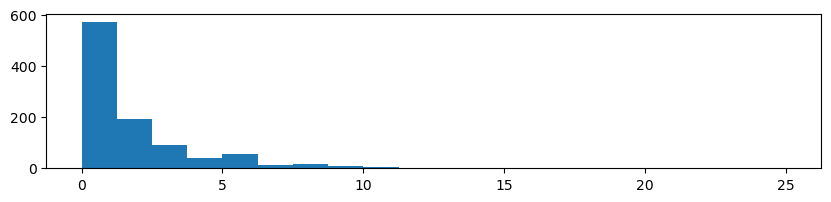

In [7]:
temperature = t.tensor(27.)
state = init_state.detach().clone()
for i in range(40):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

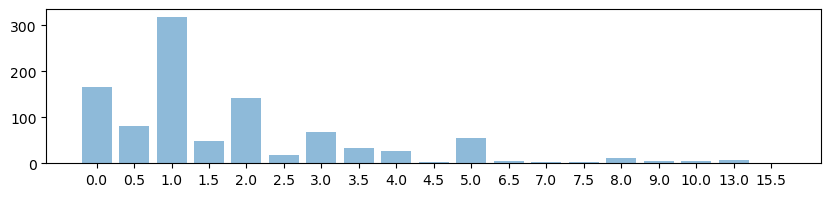

In [11]:
vals, counts = np.unique(distances.detach().numpy().round(decimals=3), return_counts=True)
plt.figure(figsize=(10,2))
plt.bar(np.arange(counts.shape[0]), counts, align='center', alpha=0.5)
plt.xticks(np.arange(counts.shape[0]), [str(val) for val in vals])
plt.show()

## 100 steps

tensor(4.3830, dtype=torch.float64) tensor(4.4451, dtype=torch.float64)


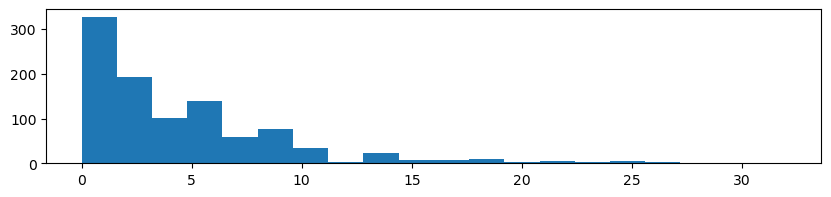

In [13]:
temperature = t.tensor(27.)
state = init_state.detach().clone()
for i in range(100):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

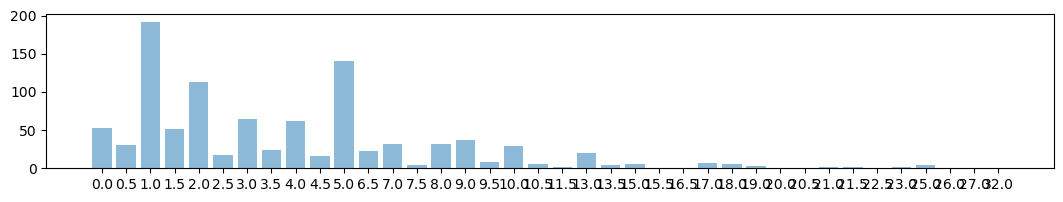

In [14]:
vals, counts = np.unique(distances.detach().numpy().round(decimals=3), return_counts=True)
plt.figure(figsize=(13,2))
plt.bar(np.arange(counts.shape[0]), counts, align='center', alpha=0.5)
plt.xticks(np.arange(counts.shape[0]), [str(val) for val in vals])
plt.show()

## 500 steps

tensor(21.7270, dtype=torch.float64) tensor(21.7711, dtype=torch.float64)


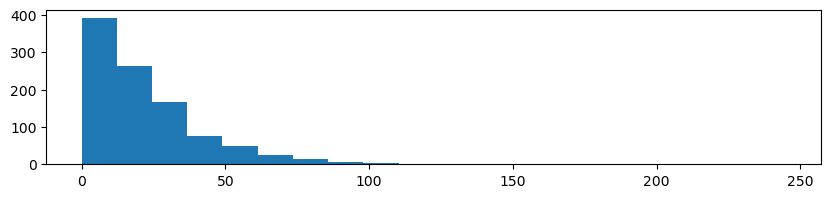

In [15]:
temperature = t.tensor(27.)
state = init_state.detach().clone()
for i in range(500):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

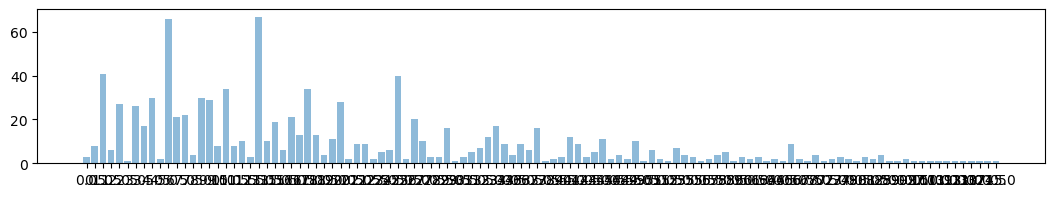

In [16]:
vals, counts = np.unique(distances.detach().numpy().round(decimals=3), return_counts=True)
plt.figure(figsize=(13,2))
plt.bar(np.arange(counts.shape[0]), counts, align='center', alpha=0.5)
plt.xticks(np.arange(counts.shape[0]), [str(val) for val in vals])
plt.show()

# Temperature 13 

## 40 Steps

tensor(1.6025, dtype=torch.float64) tensor(1.8584, dtype=torch.float64)


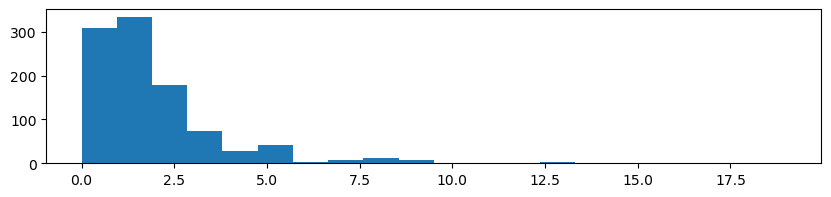

In [17]:
temperature = t.tensor(13.)
state = init_state.detach().clone()
for i in range(40):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

## 100 Steps

tensor(3.9215, dtype=torch.float64) tensor(3.8793, dtype=torch.float64)


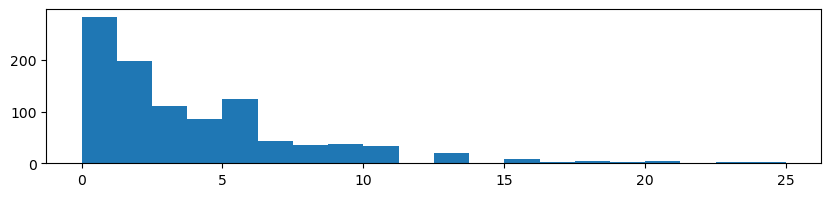

In [19]:
temperature = t.tensor(13.)
state = init_state.detach().clone()
for i in range(100):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

## 500 Steps

tensor(19.9710, dtype=torch.float64) tensor(21.3059, dtype=torch.float64)


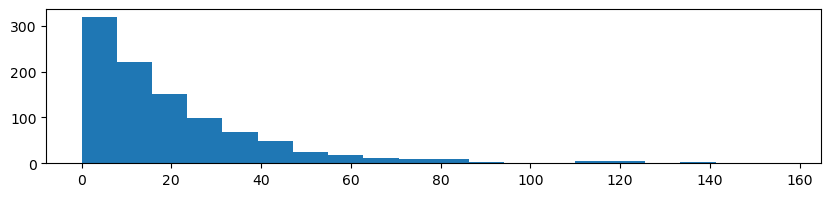

In [20]:
temperature = t.tensor(13.)
state = init_state.detach().clone()
for i in range(500):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

# Temperature 6

## 40 Steps

tensor(1.2225, dtype=torch.float64) tensor(1.4143, dtype=torch.float64)


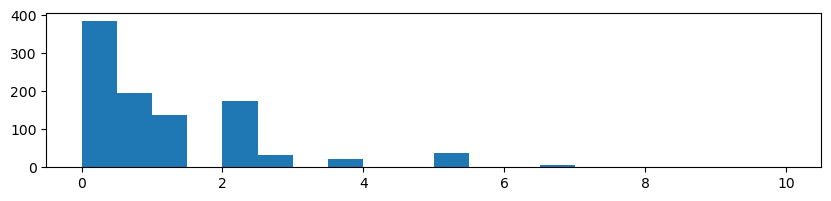

In [21]:
temperature = t.tensor(6.)
state = init_state.detach().clone()
for i in range(40):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

## 100 Steps

tensor(2.9780, dtype=torch.float64) tensor(3.2202, dtype=torch.float64)


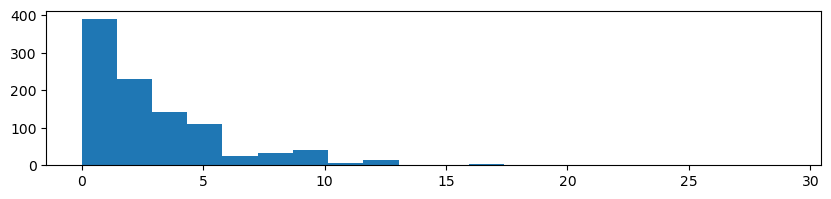

In [22]:
temperature = t.tensor(6.)
state = init_state.detach().clone()
for i in range(100):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

## 500 Steps

tensor(14.5275, dtype=torch.float64) tensor(15.5423, dtype=torch.float64)


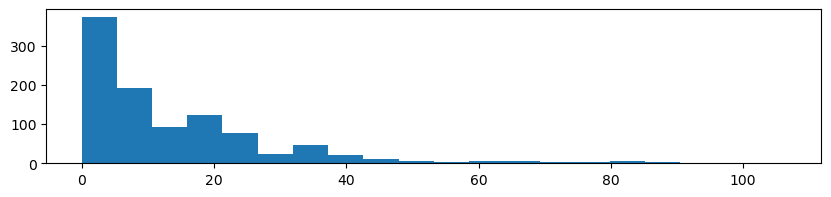

In [23]:
temperature = t.tensor(6.)
state = init_state.detach().clone()
for i in range(500):
    state = MCS(state, target_vol, temperature)
distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
print(t.mean(distances), t.std(distances))
plt.figure(figsize=(10,2))
plt.hist(distances.detach().numpy(), bins=20)
plt.show()

# Plotting mean distances over temperatures

In [25]:
temperatures = t.linspace(1, 27, 27)
mean_distances = []
std_distances = []

for temp in temperatures:
    state = init_state.detach().clone()
    for i in range(100):
        state = MCS(state, target_vol, temp)
    distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
    print(t.mean(distances), t.std(distances))
    mean_distances.append(t.mean(distances))
    std_distances.append(t.std(distances))

tensor(0.1375, dtype=torch.float64) tensor(0.4823, dtype=torch.float64)
tensor(1.0575, dtype=torch.float64) tensor(1.4882, dtype=torch.float64)
tensor(1.7660, dtype=torch.float64) tensor(2.2258, dtype=torch.float64)
tensor(2.5040, dtype=torch.float64) tensor(2.8956, dtype=torch.float64)
tensor(2.9260, dtype=torch.float64) tensor(3.1748, dtype=torch.float64)
tensor(3.1200, dtype=torch.float64) tensor(3.4196, dtype=torch.float64)
tensor(3.2435, dtype=torch.float64) tensor(3.7102, dtype=torch.float64)
tensor(3.5065, dtype=torch.float64) tensor(4.0282, dtype=torch.float64)
tensor(3.5665, dtype=torch.float64) tensor(3.8841, dtype=torch.float64)
tensor(3.5330, dtype=torch.float64) tensor(3.8356, dtype=torch.float64)
tensor(3.8790, dtype=torch.float64) tensor(4.1863, dtype=torch.float64)
tensor(3.9720, dtype=torch.float64) tensor(4.3810, dtype=torch.float64)
tensor(4.0060, dtype=torch.float64) tensor(4.3114, dtype=torch.float64)
tensor(4.1270, dtype=torch.float64) tensor(4.1987, dtype=torch.f

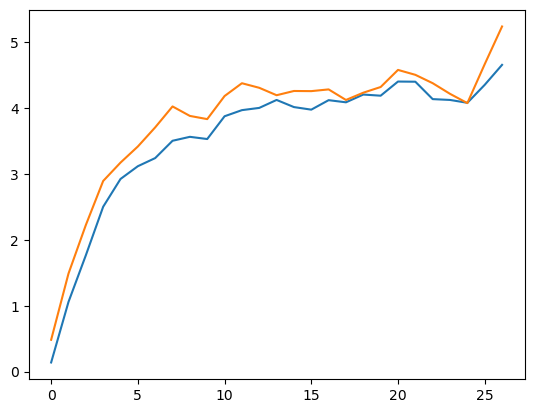

In [26]:
plt.plot(np.arange(27), mean_distances)
plt.plot(np.arange(27), std_distances)
plt.show()

In [11]:
temperatures = t.linspace(1, 35, 35)
mean_distances = []
std_distances = []

init_state = t.zeros(5000,128,128)
init_state[:,32,32] += 1
ref_state = init_state.detach().clone()

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state[0], return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix)
print(dist_matrix_t)

target_vol = 0.

for temp in temperatures:
    state = init_state.detach().clone()
    for i in range(100):
        state = MCS(state, target_vol, temp)
    distances = t.sum(state * dist_matrix_t, dim=(-1,-2)) / t.sum(state, dim=(-1,-2))
    print(t.mean(distances), t.std(distances))
    mean_distances.append(t.mean(distances))
    std_distances.append(t.std(distances))

tensor([[ 2048.0000,  1985.0000,  1924.0000,  ...,  9673.0000,  9860.0000,
         10049.0000],
        [ 1985.0000,  1922.0000,  1861.0000,  ...,  9610.0000,  9797.0000,
          9986.0000],
        [ 1924.0000,  1861.0000,  1800.0000,  ...,  9549.0000,  9736.0000,
          9925.0000],
        ...,
        [ 9673.0000,  9610.0000,  9549.0000,  ..., 17298.0000, 17485.0000,
         17674.0000],
        [ 9860.0000,  9797.0000,  9736.0000,  ..., 17485.0000, 17672.0000,
         17861.0000],
        [10049.0000,  9986.0000,  9925.0000,  ..., 17674.0000, 17861.0000,
         18050.0000]], dtype=torch.float64)
tensor(0.1390, dtype=torch.float64) tensor(0.4778, dtype=torch.float64)
tensor(1.0188, dtype=torch.float64) tensor(1.4620, dtype=torch.float64)
tensor(1.8786, dtype=torch.float64) tensor(2.3655, dtype=torch.float64)
tensor(2.3791, dtype=torch.float64) tensor(2.7211, dtype=torch.float64)
tensor(2.7449, dtype=torch.float64) tensor(3.0520, dtype=torch.float64)
tensor(3.0418, dtype=to

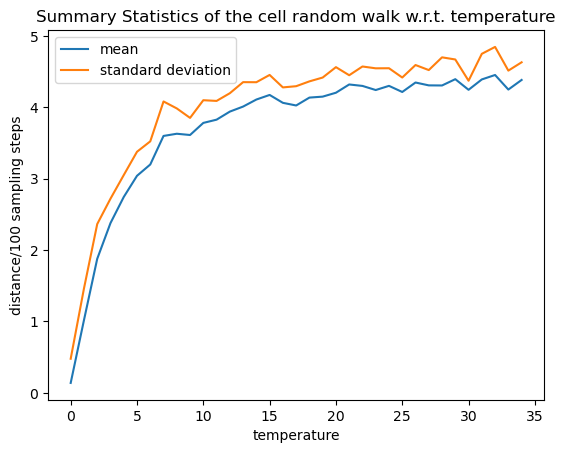

In [17]:
plt.plot(np.arange(35), mean_distances, label="mean")
plt.plot(np.arange(35), std_distances, label="standard deviation")
plt.xlabel("temperature")
plt.ylabel("distance/100 sampling steps")
plt.legend()
plt.title("Summary Statistics of the cell random walk w.r.t. temperature")
plt.show()